In [88]:
import torch
import torch.nn.functional as F
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

cuda


# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [89]:
# creates the training set of trigrams (x, y)
xs, ys = [], []

for w in words:
    # Trigram context requires TWO starting characters
    # If word is 'emma', context is:
    # .. -> e
    # .e -> m
    # em -> m
    # mm -> a
    # ma -> .
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3] # target
        # Create a unique idx for the input pair (ch1, ch2)
        # this maps (0, 0) -> 0, (0, 1) -> 1 ... (26, 26) -> 728
        trigram_idx = ix1 * 27 + ix2 # base-27
        xs.append(trigram_idx)
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)
xs = xs.to(device)
ys = ys.to(device)

number of examples:  228146


In [90]:
# initialize the 'network'
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27*27, 27), generator=g, requires_grad=True, device=device)
# gradient descent
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27*27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # W -> zero, the more smooth distribution you're going achieve, 
    # 0.01 * (W**2).mean() called regularization
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    if k % 10 == 0:
        print(f'idx: {k}, loss: {loss.item()}')

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

idx: 0, loss: 3.762385368347168
idx: 10, loss: 3.2260546684265137
idx: 20, loss: 2.9909610748291016
idx: 30, loss: 2.8569254875183105
idx: 40, loss: 2.7668895721435547
idx: 50, loss: 2.7005512714385986
idx: 60, loss: 2.6489357948303223
idx: 70, loss: 2.607341766357422
idx: 80, loss: 2.5730233192443848
idx: 90, loss: 2.5442166328430176


In [91]:
g = torch.Generator(device=device).manual_seed(2147483647)
for i in range(5):
    out = []
    ix1 = 0 # .
    ix2 = 0 # .
    while True:
        # ---------- CHANGE START ----------
        
        # 1. Turn the integer index 'ix' into a Tensor
        x = torch.tensor([ix1 * 27 + ix2])
        x = x.to(device)
        
        # 2. One-hot encode the input (creates shape 1x(27*27))
        # We must cast to .float() because W is float, but one_hot creates integers
        xenc = F.one_hot(x, num_classes=27*27).float()
        
        # 3. Forward Pass: Calculate Logits
        logits = xenc @ W 
        
        # 4. Softmax: Convert Logits to Probabilities
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        
        # ---------- CHANGE END ----------
        
        # 5. Sample from the distribution (Same as before)
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix3 == 0:
            break
        out.append(itos[ix3])
        ix1 = ix2
        ix2 = ix3
    
    print(''.join(out))

khed
epwylingyyzlbgomi
ana
maqkscyamicxobriafxine
delenlzdu


In [92]:
g = torch.Generator(device=device).manual_seed(2147483647)
for i in range(5):
    out = []
    ix1 = 0 # .
    ix2 = 0 # .
    while True:
        # ---------- CHANGE START ----------
        
        # 1. Turn the integer index 'ix' into a Tensor
        # x = torch.tensor([ix1 * 27 + ix2])
        
        # 2. One-hot encode the input (creates shape 1x(27*27))
        # We must cast to .float() because W is float, but one_hot creates integers
        # xenc = F.one_hot(x, num_classes=27*27).float()
        
        # 3. Forward Pass: Calculate Logits
        # logits = xenc @ W 


        # OPTIMIZATION
        # Multiply a one-hot vector by a matrix is exactly the same as plucking out a single
        # row from that matrix

        logits = W[ix1 * 27 + ix2]
        
        # 4. Softmax: Convert Logits to Probabilities
        counts = logits.exp()
        p = counts / counts.sum()
        
        # ---------- CHANGE END ----------
        
        # 5. Sample from the distribution (Same as before)
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix3 == 0:
            break
        out.append(itos[ix3])
        ix1 = ix2
        ix2 = ix3
    
    print(''.join(out))

khed
epwylingyyzlbgomi
ana
maqkscyamicxobriafxine
delenlzdu


|Epoches|Bigram loss|Trigram loss|
|:-----:|-----------|------------|
|50   |   2.49662 |**2.6964**|
|100  |   2.47    |2.51169|
|200  |   2.461897|2.37919|
|2000 |   **2.454**   |**2.2116**|

1. when epoches very small, like 50 or 100. loss of Trigram large Bigram. so complex network needs more epoches to feed neurons. for large epoches, complex network have lower loss. means its complex allow it fit data greatly.
2. when epoch increase, Bigram loss seems decrease **slowly**. But Trigram loss seems decreases quickly. so Trigram's capacity allow its learn more information from 2-order data but Bigram seems its limited network prevent its learning.
3. if data limited, use shallow network instead of complex network, otherwise not feed it up.

# E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [105]:
# 1. Shuffle (Crucial! Otherwise you might train on A->S and test on T-Z)
random.seed(42)
random.shuffle(words)

# 2. Calculate split points
n_e03 = int(0.2 * len(words)) # 80% mark
n1 = int(0.8 * len(words)) # 80% mark
n2 = int(0.9 * len(words)) # 80% mark

# 3. Slice
words_train = words[:n_e03]  # 80%
words_dev = words[n1:n2] # 80%-90%
words_test = words[n2:]  # 90%-100%

print(len(words_train), len(words_dev), len(words_test))

6406 3203 3204


In [106]:
def build_dataset(words):
    xs, ys = [], []
    for w in words:
        # Trigram context: start with two dots
        chs = ['.'] + ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            
            # Trigram logic: (27 * ch1) + ch2
            xs.append(ix1 * 27 + ix2)
            ys.append(ix3)
    
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xs = xs.to(device)
    ys = ys.to(device)
    print(f'Dataset has {xs.nelement()} examples')
    return xs, ys

# Build the three sets
print("Building Train...")
Tri_Xtr, Tri_Ytr = build_dataset(words_train)
print("Building Dev...")
Tri_Xdev, Tri_Ydev = build_dataset(words_dev)
print("Building Test...")
Tri_Xte, Tri_Yte = build_dataset(words_test)

Building Train...
Dataset has 45693 examples
Building Dev...
Dataset has 22767 examples
Building Test...
Dataset has 22799 examples


In [95]:
for alpha in np.arange(0, 0.1, 0.05):
    print(f"\nAlpha: {alpha}")
    # Initialize network (Trigram: 729 inputs -> 27 outputs)
    g = torch.Generator(device=device).manual_seed(2147483647)
    W = torch.randn((27*27, 27), generator=g, requires_grad=True, device=device)
    
    # --- TRAINING (only on Xtr, Ytr) ---
    for k in range(50): # Increase this to ~1000 or more for good results
        # Forward pass
        xenc = F.one_hot(Tri_Xtr, num_classes=27*27).float()
        logits = xenc @ W
        
        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        
        # Loss
        loss = -probs[torch.arange(len(Tri_Ytr)), Tri_Ytr].log().mean() + alpha * (W**2).mean()
        
        # Backward
        W.grad = None
        loss.backward()
        W.data += -50 * W.grad
    
    print(f"Training Loss: {loss.item()}")
    # --- EVALUATION (on Xdev, Ydev) ---
    # We do NOT optimize W here, we just calculate loss
    with torch.no_grad(): # Tells torch we don't need gradients here
        xenc_dev = F.one_hot(Tri_Xdev, num_classes=27*27).float()
        logits_dev = xenc_dev @ W
        counts_dev = logits_dev.exp()
        probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)
        loss_dev = -probs_dev[torch.arange(len(Tri_Ydev)), Tri_Ydev].log().mean()

    print(f"Dev Loss: {loss_dev.item()}")

    # --- TEST (on Xte, Yte) ---
    with torch.no_grad():
        xenc_test = F.one_hot(Tri_Xte, num_classes=27*27).float()
        logits_test = xenc_test @ W
        counts_test = logits_test.exp()
        probs_test = counts_test / counts_test.sum(1, keepdim =True)
        loss_test = -probs_test[torch.arange(len(Tri_Yte)), Tri_Yte].log().mean()
        # Usually we DO NOT include regularization in test/dev loss
        # because regularization is a training penalty,
        # not part of the true model performance.
    print(f"Test Loss: {loss_test.item()}")


Alpha: 0.0
Training Loss: 2.6972665786743164
Dev Loss: 2.6845288276672363
Test Loss: 2.698153018951416

Alpha: 0.05
Training Loss: 2.7422003746032715
Dev Loss: 2.6827549934387207
Test Loss: 2.696232795715332


In [96]:
# Bigram 
def build_dataset(words):
    xs, ys = [], []
    for w in words:
        # Bigram context: start with one dots
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            xs.append(ix1)
            ys.append(ix2)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xs = xs.to(device)
    ys = ys.to(device)
    print(f'Dataset has {xs.nelement()} examples')
    return xs, ys

# Build the three sets
print("Building Train...")
Bi_Xtr, Bi_Ytr = build_dataset(words_train)
print("Building Dev...")
Bi_Xdev, Bi_Ydev = build_dataset(words_dev)
print("Building Test...")
Bi_Xte, Bi_Yte = build_dataset(words_test)

Building Train...
Dataset has 182625 examples
Building Dev...
Dataset has 22655 examples
Building Test...
Dataset has 22866 examples


In [97]:
for alpha in np.arange(0, 0.1, 0.05):
    print(f"\nAlpha: {alpha}")
    g = torch.Generator(device=device).manual_seed(2147483647)
    W = torch.randn((27, 27), generator=g, requires_grad=True, device=device)
    
    # --- TRAINING (only on Xtr, Ytr) ---
    for k in range(50): # Increase this to ~1000 or more for good results
        # Forward pass
        xenc = F.one_hot(Bi_Xtr, num_classes=27).float()
        logits = xenc @ W
        
        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        
        # Loss
        loss = -probs[torch.arange(len(Bi_Xtr)), Bi_Ytr].log().mean() + alpha * (W**2).mean()
        
        # Backward
        W.grad = None
        loss.backward()
        W.data += -50 * W.grad
    
    print(f"Training Loss: {loss.item()}")
    # --- EVALUATION (on Xdev, Ydev) ---
    # We do NOT optimize W here, we just calculate loss
    with torch.no_grad(): # Tells torch we don't need gradients here
        xenc_dev = F.one_hot(Bi_Xdev, num_classes=27).float()
        logits_dev = xenc_dev @ W
        counts_dev = logits_dev.exp()
        probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)
        loss_dev = -probs_dev[torch.arange(len(Bi_Ydev)), Bi_Ydev].log().mean()
    
    print(f"Dev Loss: {loss_dev.item()}")

    # --- TEST (on Xte, Yte) ---
    with torch.no_grad():
        xenc_test = F.one_hot(Bi_Xte, num_classes=27).float()
        logits_test = xenc_test @ W
        counts_test = logits_test.exp()
        probs_test = counts_test / counts_test.sum(1, keepdims=True)
        loss_test = -probs_test[torch.arange(len(Bi_Yte)), Bi_Yte].log().mean()
        # Usually we DO NOT include regularization in test/dev loss
        # because regularization is a training penalty,
        # not part of the true model performance.
    print(f"Test Loss: {loss_test.item()}")


Alpha: 0.0
Training Loss: 2.496650457382202
Dev Loss: 2.492772340774536
Test Loss: 2.500807285308838

Alpha: 0.05
Training Loss: 2.5556743144989014
Dev Loss: 2.501662492752075
Test Loss: 2.508352518081665


epoch = 2000
## Trigram
1. Alpha: 0.0
2. Training Loss: 2.2116944789886475
3. Dev Loss: 2.2344369888305664
4. Test Loss: 2.235217571258545
## Bigram
1. Alpha: 0.0
2. Training Loss: 2.45473575592041
3. Dev Loss: 2.4530274868011475
4. Test Loss: 2.458131790161133

1. 可以发现Trigram loss更低，说明其参数容量允许其进一步收敛，建模更多统计数据。但dev和test loss > train loss，说明？[模型开始记住数据中的噪声，过拟合]
2. Bigram loss较高，其参数容量无法表达更复杂的结构。同时三个loss之间都比较接近。说明？[几乎没有过拟合，其模型容量不允许其overfit，尽管epoch很大]
3. train and dev loss relationship:
   1. train << dev -> overfit
   2. train almost = dev -> underfit or capacity of network limited
4. loss between trigram and bigram: loss trigram lower -> 2-order context provide more extra information.
5. other problems?


# E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
alphas = []
train_losses = []
dev_losses = []

for alpha in np.arange(0, 0.05, 0.005):
    alphas.append(alpha)
    print(f"\nAlpha: {alpha}")
    # Initialize network (Trigram: 729 inputs -> 27 outputs)
    g = torch.Generator(device=device).manual_seed(2147483647)
    W = torch.randn((27*27, 27), generator=g, requires_grad=True, device=device)
    
    # --- TRAINING (only on Xtr, Ytr) ---
    for k in range(500): # Increase this to ~1000 or more for good results
        # Forward pass
        xenc = F.one_hot(Tri_Xtr, num_classes=27*27).float()
        logits = xenc @ W
        
        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        
        # Loss
        loss = -probs[torch.arange(len(Tri_Ytr)), Tri_Ytr].log().mean() + alpha * (W**2).mean()
        
        # Backward
        W.grad = None
        loss.backward()
        W.data += -50 * W.grad
    
    print(f"Training Loss: {loss.item()}")
    train_losses.append(loss.item())
    
    # --- EVALUATION (on Xdev, Ydev) ---
    # We do NOT optimize W here, we just calculate loss
    with torch.no_grad(): # Tells torch we don't need gradients here
        xenc_dev = F.one_hot(Tri_Xdev, num_classes=27*27).float()
        logits_dev = xenc_dev @ W
        counts_dev = logits_dev.exp()
        probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)
        loss_dev = -probs_dev[torch.arange(len(Tri_Ydev)), Tri_Ydev].log().mean()

    print(f"Dev Loss: {loss_dev.item()}")
    dev_losses.append(loss_dev.item())


Alpha: 0.0
Training Loss: 2.247952461242676
Dev Loss: 2.3174901008605957

Alpha: 0.005
Training Loss: 2.2541582584381104
Dev Loss: 2.31742525100708

Alpha: 0.01
Training Loss: 2.2601585388183594
Dev Loss: 2.317377805709839

Alpha: 0.015
Training Loss: 2.2659599781036377
Dev Loss: 2.317347764968872

Alpha: 0.02
Training Loss: 2.2715699672698975
Dev Loss: 2.3173348903656006

Alpha: 0.025
Training Loss: 2.276995897293091
Dev Loss: 2.317338705062866

Alpha: 0.03
Training Loss: 2.282243490219116
Dev Loss: 2.3173584938049316

Alpha: 0.035
Training Loss: 2.287320137023926
Dev Loss: 2.317394256591797

Alpha: 0.04
Training Loss: 2.292231798171997
Dev Loss: 2.3174455165863037

Alpha: 0.045
Training Loss: 2.2969841957092285
Dev Loss: 2.317512035369873


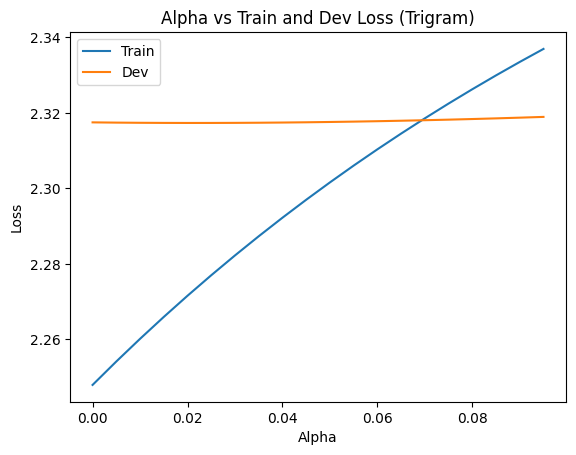

In [115]:
plt.figure()
plt.plot(alphas, train_losses)
plt.plot(alphas, dev_losses)

plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.title("Alpha vs Train and Dev Loss (Trigram)")
plt.legend(["Train", "Dev"])

plt.show()

In [113]:
for alpha in np.arange(0.05, 0.1, 0.005):
    alphas.append(alpha)
    print(f"\nAlpha: {alpha}")
    # Initialize network (Trigram: 729 inputs -> 27 outputs)
    g = torch.Generator(device=device).manual_seed(2147483647)
    W = torch.randn((27*27, 27), generator=g, requires_grad=True, device=device)
    
    # --- TRAINING (only on Xtr, Ytr) ---
    for k in range(500): # Increase this to ~1000 or more for good results
        # Forward pass
        xenc = F.one_hot(Tri_Xtr, num_classes=27*27).float()
        logits = xenc @ W
        
        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        
        # Loss
        loss = -probs[torch.arange(len(Tri_Ytr)), Tri_Ytr].log().mean() + alpha * (W**2).mean()
        
        # Backward
        W.grad = None
        loss.backward()
        W.data += -50 * W.grad
    
    print(f"Training Loss: {loss.item()}")
    train_losses.append(loss.item())
    
    # --- EVALUATION (on Xdev, Ydev) ---
    # We do NOT optimize W here, we just calculate loss
    with torch.no_grad(): # Tells torch we don't need gradients here
        xenc_dev = F.one_hot(Tri_Xdev, num_classes=27*27).float()
        logits_dev = xenc_dev @ W
        counts_dev = logits_dev.exp()
        probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)
        loss_dev = -probs_dev[torch.arange(len(Tri_Ydev)), Tri_Ydev].log().mean()

    print(f"Dev Loss: {loss_dev.item()}")
    dev_losses.append(loss_dev.item())


Alpha: 0.05
Training Loss: 2.3015832901000977
Dev Loss: 2.3175933361053467

Alpha: 0.055
Training Loss: 2.306034803390503
Dev Loss: 2.3176889419555664

Alpha: 0.06
Training Loss: 2.3103435039520264
Dev Loss: 2.3177988529205322

Alpha: 0.065
Training Loss: 2.3145158290863037
Dev Loss: 2.317922830581665

Alpha: 0.06999999999999999
Training Loss: 2.318556308746338
Dev Loss: 2.3180599212646484

Alpha: 0.07499999999999998
Training Loss: 2.3224692344665527
Dev Loss: 2.3182103633880615

Alpha: 0.07999999999999999
Training Loss: 2.3262598514556885
Dev Loss: 2.318373680114746

Alpha: 0.08499999999999999
Training Loss: 2.3299331665039062
Dev Loss: 2.318549633026123

Alpha: 0.08999999999999998
Training Loss: 2.3334927558898926
Dev Loss: 2.318737745285034

Alpha: 0.09499999999999997
Training Loss: 2.336942672729492
Dev Loss: 2.3189377784729004


In [116]:
print(alphas)
print(train_losses)
print(dev_losses)
dev_losses = np.array(dev_losses)

best_index = np.argmin(dev_losses)
best_alpha = alphas[best_index]
best_dev_loss = dev_losses[best_index]

print("Best index:", best_index)
print("Best alpha:", best_alpha)
print("Best dev loss:", best_dev_loss)

[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.06999999999999999, 0.07499999999999998, 0.07999999999999999, 0.08499999999999999, 0.08999999999999998, 0.09499999999999997]
[2.247952461242676, 2.2541582584381104, 2.2601585388183594, 2.2659599781036377, 2.2715699672698975, 2.276995897293091, 2.282243490219116, 2.287320137023926, 2.292231798171997, 2.2969841957092285, 2.3015832901000977, 2.306034803390503, 2.3103435039520264, 2.3145158290863037, 2.318556308746338, 2.3224692344665527, 2.3262598514556885, 2.3299331665039062, 2.3334927558898926, 2.336942672729492]
[2.3174901008605957, 2.31742525100708, 2.317377805709839, 2.317347764968872, 2.3173348903656006, 2.317338705062866, 2.3173584938049316, 2.317394256591797, 2.3174455165863037, 2.317512035369873, 2.3175933361053467, 2.3176889419555664, 2.3177988529205322, 2.317922830581665, 2.3180599212646484, 2.3182103633880615, 2.318373680114746, 2.318549633026123, 2.318737745285034, 2.3189377784729004]


In [117]:
alpha = 0.02
print(f"\nAlpha: {alpha}")
# Initialize network (Trigram: 729 inputs -> 27 outputs)
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27*27, 27), generator=g, requires_grad=True, device=device)

# --- TRAINING (only on Xtr, Ytr) ---
for k in range(500): # Increase this to ~1000 or more for good results
    # Forward pass
    xenc = F.one_hot(Tri_Xtr, num_classes=27*27).float()
    logits = xenc @ W
    
    # Softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    
    # Loss
    loss = -probs[torch.arange(len(Tri_Ytr)), Tri_Ytr].log().mean() + alpha * (W**2).mean()
    
    # Backward
    W.grad = None
    loss.backward()
    W.data += -50 * W.grad

print(f"Training Loss: {loss.item()}")

# --- EVALUATION (on Xdev, Ydev) ---
# We do NOT optimize W here, we just calculate loss
with torch.no_grad(): # Tells torch we don't need gradients here
    xenc_dev = F.one_hot(Tri_Xdev, num_classes=27*27).float()
    logits_dev = xenc_dev @ W
    counts_dev = logits_dev.exp()
    probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)
    loss_dev = -probs_dev[torch.arange(len(Tri_Ydev)), Tri_Ydev].log().mean()

print(f"Dev Loss: {loss_dev.item()}")


Alpha: 0.02
Training Loss: 2.2715699672698975
Dev Loss: 2.3173348903656006


In [118]:
# --- TEST (on Xte, Yte) ---
with torch.no_grad():
    xenc_test = F.one_hot(Tri_Xte, num_classes=27*27).float()
    logits_test = xenc_test @ W
    counts_test = logits_test.exp()
    probs_test = counts_test / counts_test.sum(1, keepdim =True)
    loss_test = -probs_test[torch.arange(len(Tri_Yte)), Tri_Yte].log().mean()
    # Usually we DO NOT include regularization in test/dev loss
    # because regularization is a training penalty,
    # not part of the true model performance.
print(f"Test Loss: {loss_test.item()}")

Test Loss: 2.3165476322174072


# chatgpt say:
1. normally we can find dev loss first decrease because suitable alpha can control overfit. then dev loss will increase \
because large alpha will harm model learning -> **U** shape
2. if dev loss **monotonously increase** means model still underfit or fit fine but not overfit. so small alpha will not influence model. but large alpha still harm it.
3. so simulate overfit. we just use 20% dataset as train set.
